<a href="https://colab.research.google.com/github/EricCallaway/COSC_5313_homework_6/blob/main/AI_homework_6_LSTM_PyTorch_blog_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import neccessary libraries

In [20]:
#@title Install/Import Libraries { vertical-output: true }

def import_install(id: str):
  import importlib
  try:
    re = importlib.import_module(id)
    print(f'import {id}')
    return re
  except ImportError:
    !python3 -m pip install --quiet --upgrade {id}
    re = importlib.import_module(id)
    print(f'install {id}')
    return re

In [21]:
torch = import_install('torch')
nn = torch.nn

import torch


In [7]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 6.4 MB 10.9 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [38]:
import os
import time
import datetime
import pathlib
import seaborn
import matplotlib.pyplot as plt
import torch
import numpy as np
import pandas as pd
import yfinance as yf
import torch as nn

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Mounted at /content/drive


In [14]:
#@title Get Stock Data { vertical-output: true }
run = True #@param {type:"boolean"}
cache_path = "./data.csv" #@param {type:"string"}
ticker = "TSLA" #@param {type:"string"}
period = "1y" #@param {type:"string"}
interval = "1h" #@param {type:"string"}
auto_adjust = True #@param {type:"boolean"}
prepost = True #@param {type:"boolean"}
threads = 0 #@param {type:"integer"}

In [15]:

if threads == 0:
  threads = False
proxy = "" #@param {type:"string"}
if proxy == "":
  proxy = None
if run:
  df = yf.download(
      ticker
      )
  df.to_csv(cache_path)
  df = pd.read_csv(cache_path)
  # ensure consistency beyween run = True and False
  print('successfully fetched data from yfinance & saved to cache')
else:
  df = pd.read_csv(cache_path)
  print('successfully fetched data from cache')
df = df.dropna()
df['Average'] = df[['High', 'Low']].mean(axis=1)
df['Date'] = pd.to_datetime(df['Date'])
df['DateNum'] = df['Date'].values.astype(np.int64) // 10 ** 9
print('successfully added columns: Average, DateNum')

[*********************100%***********************]  1 of 1 completed
successfully fetched data from yfinance & saved to cache
successfully added columns: Average, DateNum


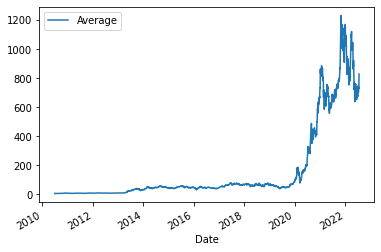

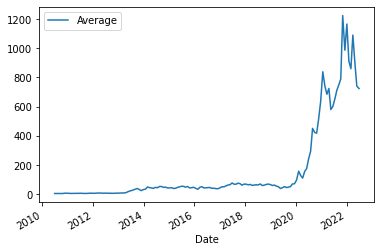

In [16]:
#@title Graph Data { run: "auto", vertical-output: true }
dep_cols = ['Average'] #@param {type:"raw"}
indep_col = 'Date' #@param {type:"string"}
start = 0 #@param {type:"integer"}
stop =  -1#@param {type:"integer"}
step =  20#@param {type:"integer"}
plot_features = df[dep_cols]
plot_features.index = df[indep_col]
_ = plot_features.plot(subplots=True)
plot_features = df[dep_cols][start:stop:step]
plot_features.index = df[indep_col][start:stop:step]
_ = plot_features.plot(subplots=True)

In [17]:
#@title Split & Normalize Data

train = 0.7 #@param {type:"number"}
val = 0.2 #@param {type:"number"}
test = 0.1 #@param {type:"number"}

normalize = True #@param {type:"boolean"}

dep_cols =  ['Average'] #@param {type:"raw"}
indep_cols = ['DateNum'] #@param {type:"raw"}

def without(d, *keys):
    new_d = d.copy()
    for key in keys:
      new_d.pop(key)
    return new_d

del_cols = list(df.columns) # columns to be removed
for dep_col in dep_cols:
  del_cols.pop(del_cols.index(dep_col))
for indep_col in indep_cols:
  del_cols.pop(del_cols.index(indep_col))
df_only = without(df, *del_cols)
avg_data = df_only['Average'].values.astype(float)

l = len(avg_data)
train_data = avg_data[0:int(l*train)]
val_data = avg_data[int(l*train):int(l*(train+val))]
test_data = avg_data[int(l*(train+val)):]

mean = avg_data.mean()
std = avg_data.std()

if normalize:
  train_data = (train_data - mean) / std
  val_data = (val_data - mean) / std
  test_data = (test_data - mean) / std
  # num_data = (num_data - mean) / std
  # train_df = (train_df - train_mean) / train_std
  # val_df = (val_df - train_mean) / train_std
  # test_df = (test_df - train_mean) / train_std

print(f'train:\t{len(train_data)}')
print(f'val:\t{len(val_data)}')
print(f'test:\t{len(test_data)}')

train:	2126
val:	608
test:	304


In [18]:
#@title Convert Data to Tensors

def create_inout_sequences(input_data, tw):
  inout_seq = []
  for i in range(len(input_data)-tw):
    train_seq = input_data[i:i+tw]
    train_label = input_data[i+tw:i+tw+1]
    inout_seq.append((train_seq ,train_label))
  return inout_seq

raw_train_data = train_data
train_data = torch.FloatTensor(train_data).view(-1)
train_window = 12

raw_val_data = val_data
val_data = torch.FloatTensor(val_data).view(-1)

raw_test_data = test_data
test_data = torch.FloatTensor(test_data).view(-1)

train_inout_seq = create_inout_sequences(train_data, train_window)

print(train_inout_seq[:5])

[(tensor([-0.5635, -0.5594, -0.5622, -0.5638, -0.5660, -0.5675, -0.5670, -0.5665,
        -0.5663, -0.5661, -0.5652, -0.5643]), tensor([-0.5639])), (tensor([-0.5594, -0.5622, -0.5638, -0.5660, -0.5675, -0.5670, -0.5665, -0.5663,
        -0.5661, -0.5652, -0.5643, -0.5639]), tensor([-0.5633])), (tensor([-0.5622, -0.5638, -0.5660, -0.5675, -0.5670, -0.5665, -0.5663, -0.5661,
        -0.5652, -0.5643, -0.5639, -0.5633]), tensor([-0.5637])), (tensor([-0.5638, -0.5660, -0.5675, -0.5670, -0.5665, -0.5663, -0.5661, -0.5652,
        -0.5643, -0.5639, -0.5633, -0.5637]), tensor([-0.5643])), (tensor([-0.5660, -0.5675, -0.5670, -0.5665, -0.5663, -0.5661, -0.5652, -0.5643,
        -0.5639, -0.5633, -0.5637, -0.5643]), tensor([-0.5638]))]


In [71]:
#@title Make Model { vertical-output: true }

#@markdown Model:
#@markdown ```
#@markdown LSTM(
#@markdown   (lstm): LSTM(1, 100)
#@markdown   (linear): Linear(in_features=100, out_features=1, bias=True)
#@markdown )
#@markdown ```

# class LSTM(torch.nn.Module):
#   def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
#       super().__init__()
#       self.hidden_layer_size = hidden_layer_size

#       self.lstm = nn.LSTM(input_size, hidden_layer_size)

#       self.linear = nn.Linear(hidden_layer_size, output_size)

#       self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
#                           torch.zeros(1,1,self.hidden_layer_size))

#   def forward(self, input_seq):
#       lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
#       predictions = self.linear(lstm_out.view(len(input_seq), -1))
#       return predictions[-1]

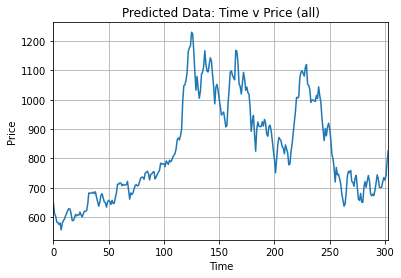

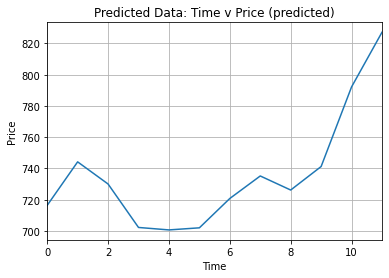

In [87]:
#@title Predict & Plot Predicted Data { vertical-output: true }
test_inputs = test_data[-train_window:].tolist()

model = torch.nn.LSTM(1,100)
x = torch.rand(64, 3, 1)
z = x.mean(1, keepdim=True)
model.eval()

plt.title('Predicted Data: Time v Price (all)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(test_data * std + mean)
x = np.arange(len(test_data)-train_window-1, len(test_data)-1, 1)
plt.show()

plt.title('Predicted Data: Time v Price (predicted)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(test_data[-train_window:] * std + mean)
x = np.arange(0, train_window, 1)
plt.show()